# Personalized Relocation Helper
This project analyzes crime data, housing prices, and points of interest (POI) data for 10 US States of Interest. The crime data includes violent, non-violent, and total crime for each state in 2018-20022. The housing prices data includes the median housing price for each state from 2018-2022. The POI data provides the number of nearby Planetariums, Dog Friendly places, and Vegan Food for cities in each state.

### Code

In [ ]:
# Dependencies and Setup
import hvplot.pandas
import pandas as pd
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import geonamescache
from config import geoapify_key
from config import crime_key

# Read in the Housing Prices CSV
housing_prices_df = pd.read_csv('housing_prices_by_state.csv', encoding='ascii')

### Crime Data
The crime data is collected using the [FBI Crime Data Explorer API]([https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/docApi](https://cde.ucr.cjis.gov/LATEST/webapp/#/pages/docApi)). The API retrieved data on several types of crime *where a charge was made* in each state from 2018-2021. The types of crime were then sorted to violent and non-violent* crimes and then totaled. This was then pivoted to more clearly display the data.

*Note: While violent and non-violent crimes both have significant consequences to individuals and communities, violent crimes are considered more serious due to the physical harm caused, and therefore separate. (see readme for a list of charges included for violent and non-violent crime)

In [24]:
# List of states to retrieve crime data for
states = ['CA', 'MI', 'TX', 'CO', 'NC', 'ME', 'MT', 'IA', 'OR', 'IL']

# API base
base_data = 'https://api.usa.gov/crime/fbi/cde/'

# Create empty dataframe to store crime data for all states
crime_df = pd.DataFrame(columns=['State', 'Year', 'Violent Crimes', 'Non-Violent Crimes', 'Total Crimes'])

# Loop through each state to retrieve data
for state in states:
    query = f'arrest/state/{state}/all?from=2018&to=2021&API_KEY='
    response = requests.get(base_data + query + crime_key)
    if response.status_code == 200:
        state_data = json.loads(response.content)['data']
    else:
        print(f"Error: API request for {state} failed with status code {response.status_code}")
        continue
    state_crime_df = pd.DataFrame(state_data)
    # Capture Year for each state
    state_crime_df = state_crime_df.rename(columns={'data_year': 'Year'})
    # Bin types of crime by Violent or Non-Violent
    state_crime_df['Violent Crimes'] = state_crime_df.loc[:, ['Aggravated Assault', 'Murder and Nonnegligent Manslaughter', 'Rape', 'Robbery']].sum(axis=1)
    state_crime_df['Non-Violent Crimes'] = state_crime_df.loc[:, ['All Other Offenses (Except Traffic)', 'Arson', 
                                                'Burglary','Curfew and Loitering Law Violations', 'Disorderly Conduct',
                                                'Driving Under the Influence', 'Drug Abuse Violations - Grand Total',
                                                'Drunkenness', 'Embezzlement', 'Forgery and Counterfeiting', 'Fraud',
                                                'Gambling - Total', 'Human Trafficking - Commercial Sex Acts',
                                                'Human Trafficking - Involuntary Servitude', 'Larceny - Theft',
                                                'Liquor Laws', 'Manslaughter by Negligence', 'Motor Vehicle Theft',
                                                'Offenses Against the Family and Children','Prostitution and Commercialized Vice',
                                                'Stolen Property: Buying, Receiving, Possessing',
                                                'Suspicion', 'Vagrancy', 'Vandalism','Weapons: Carrying, Possessing, Etc.',
                                                'Sex Offenses (Except Rape, and Prostitution and Commercialized Vice)', 'Simple Assault']].sum(axis=1)
    # Drop Types of Crimes
    state_crime_df.drop(labels=['Aggravated Assault','All Other Offenses (Except Traffic)', 'Arson', 'Burglary',
                                                'Curfew and Loitering Law Violations', 'Disorderly Conduct','Driving Under the Influence',
                                                'Drug Abuse Violations - Grand Total', 'Drunkenness', 'Embezzlement', 
                                                'Forgery and Counterfeiting', 'Fraud','Gambling - Total', 
                                                'Human Trafficking - Commercial Sex Acts', 'Human Trafficking - Involuntary Servitude',
                                                'Larceny - Theft', 'Liquor Laws', 'Manslaughter by Negligence', 'Motor Vehicle Theft',
                                                'Murder and Nonnegligent Manslaughter', 'Offenses Against the Family and Children',
                                                'Prostitution and Commercialized Vice','Rape', 'Robbery', 'Simple Assault', 
                                                'Stolen Property: Buying, Receiving, Possessing', 'Suspicion', 'Vagrancy', 'Vandalism','Weapons: Carrying, Possessing, Etc.',
                                                'Sex Offenses (Except Rape, and Prostitution and Commercialized Vice)'],axis=1, inplace=True)
    # Add Violent and Non-Violent Crimes to create Total Crimes Column
    state_crime_df['Total Crimes'] = state_crime_df.loc[:, ['Non-Violent Crimes', 'Violent Crimes']].sum(axis=1)
    # Add State name
    state_crime_df['State'] = state
    # Plug in retrieved data to the all_crime_data_df
    crime_df = pd.concat([crime_df, state_crime_df[["State", "Year", "Violent Crimes", "Non-Violent Crimes", "Total Crimes"]]])
    crime_df

In [25]:
# Pivot 
crime_pivot = crime_df.pivot_table(values=['Violent Crimes', 'Non-Violent Crimes', 'Total Crimes'], index=['State'], columns=['Year'], fill_value=0)

# Format multi-level column for clarity
crime_pivot.columns = ['{}_{}'.format(col[1], col[0]) for col in crime_pivot.columns]

# Reset the index to get the State column back
crime_pivot = crime_pivot.reset_index()

### Housing Data
The housing price data is collected from a csv file on the [Zillow Research Data](https://www.zillow.com/research/data/) website. The data was narrowed to only include 2018-2022 data for the 10 states of interest. Interpolate was used to get the average of adjacent cells in a State row when there was an absent value. The median house price for each year by state was then calculated.

In [5]:
# Drop unnecessary columns
housing_prices_df = housing_prices_df.drop(columns=['RegionID', 'SizeRank', 'RegionType', 'StateName'])

# Rename 'RegionName' 'State'
housing_prices_df = housing_prices_df.rename(columns={'RegionName': 'State'})

# Keep only States of interest
housing_prices_df = housing_prices_df[housing_prices_df['State'].isin(['California', 'Michigan', 'Texas', 'Colorado', 'North Carolina', 'Maine', 'Montana', 'Iowa', 'Oregon', 'Illinois'])]

# Rename States with abbreviations
state_abbreviations = {'California': 'CA', 'Michigan': 'MI', 'Texas': 'TX', 'Colorado': 'CO', 'North Carolina': 'NC', 'Maine': 'ME', 'Montana': 'MT', 'Iowa': 'IA', 'Oregon': 'OR', 'Illinois': 'IL'}
housing_prices_df['State'] = housing_prices_df['State'].replace(state_abbreviations)

# Select 2018 - 2022 data
columns_to_keep = [col for col in housing_prices_df.columns if col.endswith("/2018") or col.endswith("/2019") or col.endswith("/2020") or col.endswith("/2021") or col.endswith("/2022")]
columns_to_keep = ['State'] + columns_to_keep

housing_df = housing_prices_df[columns_to_keep].copy()

In [6]:
# Set the State column as the index
housing_df = housing_df.set_index('State')

# Interpolate missing values along the rows(states)
housing_df = housing_df.interpolate(axis=1)

housing_df = housing_df.astype(int)

# Reset the index
housing_df = housing_df.reset_index()

In [7]:
# Get the median house price for each year and state
years = ['2018', '2019', '2020', '2021', '2022']
for year in years:
    year_columns = [col for col in housing_df.columns if col.endswith(f"/{year}")]
    year_median = housing_df[year_columns].median(axis=1)
    housing_df[year] = year_median.apply(lambda x: '{:,.0f}'.format(x))

# Arrange columns
housing_df = housing_df[['State', '2018', '2019', '2020', '2021', '2022']]

### Points of Interest 
Using [GeonamesCache](https://pypi.org/project/geonamescache/), a list of cities (pop. >15000) in each of the states of interest generates. Then, [Geoapify](https://apidocs.geoapify.com/) searches for Planetariums, places where dogs are allowed, and places where you can get vegan food within a 5 mile radius of each city. These three variables were selected based on the idea of a demo client wanting to further narrow down their search for a place to relocate.

In [8]:
# Initialize GeonamesCache
gc = geonamescache.GeonamesCache()

# Get the states and cities from the GeonamesCache object
states = gc.get_us_states()
cities = gc.get_cities()

# Convert the cities dictionary to a dataframe
cities_in_states_df = pd.DataFrame(list(cities.values()), columns=list(cities.values())[0].keys())

# Filter the dataframe to only include cities in Texas, Michigan, and California
cities_in_states_df = cities_in_states_df[cities_in_states_df['admin1code'].isin(['CA', 'MI', 'TX', 'CO', 'NC', 'ME', 'MT', 'IA', 'OR', 'IL'])]


In [9]:
# Rename columns for clarity
cities_in_states_df.rename(columns={'name': 'City', 'latitude': 'Latitude', 'longitude': 'Longitude',
                                     'population': 'City Population', 'admin1code': 'State'}, inplace=True)

# Drop unnecessary columns
cities_in_states_df.drop(['geonameid', 'timezone', 'alternatenames', 'countrycode'], axis=1, inplace=True)

# Label index column
cities_in_states_df.index.rename('ID', inplace=True)

# Reorder the columns
cities_in_states_df = cities_in_states_df[['State', 'City', 'Latitude', 'Longitude', 'City Population']]

In [10]:
# Initialize GeonamesCache
gc = geonamescache.GeonamesCache()

# Get the states and cities from the GeonamesCache object
states = gc.get_us_states()
cities = gc.get_cities()

# Convert the cities dictionary to a dataframe
cities_in_states_df = pd.DataFrame(list(cities.values()), columns=list(cities.values())[0].keys())

# Filter the dataframe to only include cities in selected states
selected_states = ['CA', 'MI', 'TX', 'CO', 'NC', 'ME', 'MT', 'IA', 'OR', 'IL']
cities_in_states_df = cities_in_states_df[cities_in_states_df['admin1code'].isin(selected_states)]

# Rename columns for clarity
column_names = {'name': 'City', 'latitude': 'Latitude', 'longitude': 'Longitude',
                'population': 'City Population', 'admin1code': 'State'}
cities_in_states_df.rename(columns=column_names, inplace=True)

# Drop unnecessary columns, label index column, reorder columns
drop_columns = ['geonameid', 'timezone', 'alternatenames', 'countrycode']
cities_in_states_df = cities_in_states_df.drop(columns=drop_columns).rename_axis('ID').reset_index()
column_order = ['State', 'City', 'Latitude', 'Longitude', 'City Population']
cities_in_states_df = cities_in_states_df[column_order]

# City Poi
city_poi_df = cities_in_states_df[['Latitude', 'Longitude', 'City', 'State', 'City Population']].copy()

# Set parameters for Planetarium, Dog Friendly, and Vegan Food Places search
radius = 5 * 1609.344  # to convert to miles
categories = {'planetarium': 'entertainment.planetarium', 'dog': 'dogs', 'vegan food': 'vegan'}

# Loop through the cities to search for Planetarium, Dog Friendly, and Vegan Food Places
for category_name, category_value in categories.items():
    # Add a column for the category
    city_poi_df[f'{category_name.capitalize()}'] = ""

    # Set parameters to search for the category
    params = {'categories': category_value, 'apiKey': geoapify_key, 'limit': 300}

    for index, row in city_poi_df.iterrows():
        # Get latitude, longitude
        latitude = row['Latitude']
        longitude = row['Longitude']

        # Add the current city's latitude and longitude to the params dictionary
        params['filter'] = f'circle:{longitude},{latitude},{radius}'
        params['bias'] = f'proximity:{longitude},{latitude}'

        # Set base URL and make an API request using the params dictionary
        base_url = 'https://api.geoapify.com/v2/places'
        name_address = requests.get(base_url, params=params).json()

        # Store the number of POIs in the response in a new column in the DataFrame
        city_poi_df.loc[index, f'Num of {category_name.capitalize()}'] = len(name_address['features'])

        # Grab the first POI and store the name
        try:
            city_poi_df.loc[index, f'{category_name.capitalize()}'] = name_address['features'][0]['properties']['name']
        except (KeyError, IndexError):
            # If no POI is found: "Not {category_name.capitalize()} Friendly"
            city_poi_df.loc[index, f'{category_name.capitalize()}'] = f'Not {category_name.capitalize()} Friendly'


In [11]:
city_poi_df

,Latitude,Longitude,City,State,City Population,Planetarium,Num of Planetarium,Dog,Num of Dog,Vegan food,Num of Vegan food
0,-9.31286,125.25648,Suai,CO,21539,Not Planetarium Friendly,0.0,Not Dog Friendly,0.0,Not Vegan food Friendly,0.0
1,38.89060,-90.18428,Alton,IL,27003,Not Planetarium Friendly,0.0,Not Dog Friendly,0.0,Not Vegan food Friendly,0.0
2,38.52005,-89.98399,Belleville,IL,42034,Not Planetarium Friendly,0.0,Not Dog Friendly,0.0,Not Vegan food Friendly,0.0
3,37.72727,-89.21675,Carbondale,IL,26399,Not Planetarium Friendly,0.0,Not Dog Friendly,50.0,Not Vegan food Friendly,0.0
4,39.49615,-88.17615,Charleston,IL,21196,Not Planetarium Friendly,0.0,Not Dog Friendly,0.0,Not Vegan food Friendly,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1116,37.75018,-122.43369,Noe Valley,CA,22893,Morrison Planetarium,1.0,Joby's Dog Run,35.0,Henry's Hunan Restaurant,99.0
1117,37.71715,-122.40433,Visitacion Valley,CA,22534,Morrison Planetarium,1.0,John McLaren Park,22.0,Henry's Hunan Restaurant,69.0
1118,34.08668,-118.27023,Silver Lake,CA,32890,Samuel Oschin Planetarium,1.0,Experimental Garden Kite Hill Expanse,2.0,Flore Vegan,23.0
1119,34.07808,-118.26066,Echo Park,CA,43832,Samuel Oschin Planetarium,1.0,Experimental Garden Kite Hill Expanse,2.0,Honey Hi,22.0


In [12]:
# Rename new dataframe, drop the first names of places found for clarity
cities_poi_df = city_poi_df.drop(['Planetarium', 'Dog', 'Vegan food'], axis=1)

# Rename columns for clarity
column_names = {'Num of Planetarium': 'Num of Planetariums', 'Num of Dog': 'Num of Dog Friendly Places', 'Num of Vegan food': 'Num of Vegan Food Places'}

cities_poi_df = cities_poi_df.rename(columns=column_names)

In [13]:
# Group by state
build_state_poi_df = cities_poi_df.groupby('State', as_index=False).agg({
    'Latitude': 'first',
    'Longitude': 'first',
    'City Population': 'sum',
    'Num of Planetariums': 'sum',
    'Num of Dog Friendly Places': 'sum',
    'Num of Vegan Food Places': 'sum',
})

In [14]:
# Read html for wiki page with accurate populations
pop_df = pd.read_html("https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population")[0]

# Drop level for clarity
pop_df.columns = pop_df.columns.droplevel(0)

# List States of Interest
list_states = ['California', 'Michigan', 'Texas', 'Colorado', 'North Carolina', 'Maine', 'Montana', 'Iowa', 'Oregon', 'Illinois']

# Filter for population
state_populations = pop_df[pop_df['State or territory'].isin(list_states)][['State or territory', "July 1, 2022 (est.)"]]

# Rename the columns 
state_populations.columns = ['State', 'State Population']

# Replace state names with abbreviations
state_populations['State'] = state_populations['State'].replace(['California', 'Michigan', 'Texas', 'Colorado', 'North Carolina', 
'Maine', 'Montana', 'Iowa', 'Oregon', 'Illinois'], ['CA', 'MI', 'TX', 'CO', 'NC', 'ME', 'MT', 'IA', 'OR', 'IL'])

In [15]:
# Merge dataframes to build State POI DF
state_poi_df = build_state_poi_df.merge(state_populations, on='State')
state_poi_df.drop('City Population', axis=1, inplace=True)

In [16]:
# New dataframe to hold POIs per capita for each state
per_capita_state_poi = state_poi_df[['State', 'State Population']].copy()

# calculate per capita
per_capita_state_poi['Planetariums per Capita'] = state_poi_df['Num of Planetariums'] / state_poi_df['State Population'] * 1000000
per_capita_state_poi['Dog Friendly Places per Capita'] = state_poi_df['Num of Dog Friendly Places'] / state_poi_df['State Population'] * 1000000
per_capita_state_poi['Vegan Food Places per Capita'] = state_poi_df['Num of Vegan Food Places'] / state_poi_df['State Population'] * 1000000

# Alejandra - Show your tutor this: 

In [31]:
# New dataframe to hold Crime per capita
build_per_capita_crime = crime_pivot.merge(state_populations, on='State')

build_per_capita_crime

,State,2018_Non-Violent Crimes,2019_Non-Violent Crimes,2020_Non-Violent Crimes,2021_Non-Violent Crimes,2018_Total Crimes,2019_Total Crimes,2020_Total Crimes,2021_Total Crimes,2018_Violent Crimes,2019_Violent Crimes,2020_Violent Crimes,2021_Violent Crimes,State Population
0,CA,983087,939924,747287,75788,1093323,1044775,847866,80110,110236,104851,100579,4322,39029342.0
1,CO,221112,207010,145484,145682,229840,215756,154544,154071,8728,8746,9060,8389,5839926.0
2,IA,83436,92721,75156,63472,87503,97884,80450,68332,4067,5163,5294,4860,3200517.0
3,IL,81069,7627,5209,36276,86606,8105,5616,38036,5537,478,407,1760,12582032.0
4,ME,40149,38362,31489,28376,40906,39053,32193,29062,757,691,704,686,1385340.0
5,MI,224759,202558,148318,143026,237605,215265,161334,155711,12846,12707,13016,12685,10034113.0
6,MT,27832,29522,28109,25147,29184,31365,30256,26907,1352,1843,2147,1760,1122867.0
7,NC,289137,226366,188833,215033,303471,236235,198996,225219,14334,9869,10163,10186,10698973.0
8,OR,134219,134754,95899,85922,139027,139945,100739,91156,4808,5191,4840,5234,4240137.0
9,TX,740452,641337,483360,494114,776182,676985,515112,525082,35730,35648,31752,30968,30029572.0


In [32]:
# Copy build_per_capita 
per_capita_crime = build_per_capita_crime.copy()

# Divide each column by the 'State Population' column
per_capita_crime.iloc[:, 1:-1] = per_capita_crime.iloc[:, 1:-1].div(per_capita_crime['State Population'], axis=0)
per_capita_crime

,State,2018_Non-Violent Crimes,2019_Non-Violent Crimes,2020_Non-Violent Crimes,2021_Non-Violent Crimes,2018_Total Crimes,2019_Total Crimes,2020_Total Crimes,2021_Total Crimes,2018_Violent Crimes,2019_Violent Crimes,2020_Violent Crimes,2021_Violent Crimes,State Population
0,CA,0.025188,0.024082,0.019147,0.001942,0.028013,0.026769,0.021724,0.002053,0.002824,0.002686,0.002577,0.000111,39029342.0
1,CO,0.037862,0.035447,0.024912,0.024946,0.039357,0.036945,0.026463,0.026382,0.001495,0.001498,0.001551,0.001436,5839926.0
2,IA,0.026070,0.028971,0.023482,0.019832,0.027340,0.030584,0.025137,0.021350,0.001271,0.001613,0.001654,0.001519,3200517.0
3,IL,0.006443,0.000606,0.000414,0.002883,0.006883,0.000644,0.000446,0.003023,0.000440,0.000038,0.000032,0.000140,12582032.0
4,ME,0.028981,0.027691,0.022730,0.020483,0.029528,0.028190,0.023238,0.020978,0.000546,0.000499,0.000508,0.000495,1385340.0
5,MI,0.022399,0.020187,0.014781,0.014254,0.023680,0.021453,0.016079,0.015518,0.001280,0.001266,0.001297,0.001264,10034113.0
6,MT,0.024787,0.026292,0.025033,0.022395,0.025991,0.027933,0.026945,0.023963,0.001204,0.001641,0.001912,0.001567,1122867.0
7,NC,0.027025,0.021158,0.017650,0.020098,0.028364,0.022080,0.018600,0.021051,0.001340,0.000922,0.000950,0.000952,10698973.0
8,OR,0.031654,0.031781,0.022617,0.020264,0.032788,0.033005,0.023758,0.021498,0.001134,0.001224,0.001141,0.001234,4240137.0
9,TX,0.024657,0.021357,0.016096,0.016454,0.025847,0.022544,0.017153,0.017485,0.001190,0.001187,0.001057,0.001031,30029572.0


## Visualizations

### Crime Visualizations
Summary: The crime data is visualized using subplot to display a horizontal bar chart referencing the violent, non-violent, and total crimes per state for the 2018-2021 timeframe. ****This shows that...*

In [27]:
crime_df.head()

,State,Year,Violent Crimes,Non-Violent Crimes,Total Crimes
0,CA,2018,110236,983087,1093323
1,CA,2019,104851,939924,1044775
2,CA,2020,100579,747287,847866
3,CA,2021,4322,75788,80110
0,MI,2018,12846,224759,237605


In [28]:
crime_pivot.head()

,State,2018_Non-Violent Crimes,2019_Non-Violent Crimes,2020_Non-Violent Crimes,2021_Non-Violent Crimes,2018_Total Crimes,2019_Total Crimes,2020_Total Crimes,2021_Total Crimes,2018_Violent Crimes,2019_Violent Crimes,2020_Violent Crimes,2021_Violent Crimes
0,CA,983087,939924,747287,75788,1093323,1044775,847866,80110,110236,104851,100579,4322
1,CO,221112,207010,145484,145682,229840,215756,154544,154071,8728,8746,9060,8389
2,IA,83436,92721,75156,63472,87503,97884,80450,68332,4067,5163,5294,4860
3,IL,81069,7627,5209,36276,86606,8105,5616,38036,5537,478,407,1760
4,ME,40149,38362,31489,28376,40906,39053,32193,29062,757,691,704,686


In [35]:
per_capita_crime.head()

,State,2018_Non-Violent Crimes,2019_Non-Violent Crimes,2020_Non-Violent Crimes,2021_Non-Violent Crimes,2018_Total Crimes,2019_Total Crimes,2020_Total Crimes,2021_Total Crimes,2018_Violent Crimes,2019_Violent Crimes,2020_Violent Crimes,2021_Violent Crimes,State Population
0,CA,0.025188,0.024082,0.019147,0.001942,0.028013,0.026769,0.021724,0.002053,0.002824,0.002686,0.002577,0.000111,39029342.0
1,CO,0.037862,0.035447,0.024912,0.024946,0.039357,0.036945,0.026463,0.026382,0.001495,0.001498,0.001551,0.001436,5839926.0
2,IA,0.026070,0.028971,0.023482,0.019832,0.027340,0.030584,0.025137,0.021350,0.001271,0.001613,0.001654,0.001519,3200517.0
3,IL,0.006443,0.000606,0.000414,0.002883,0.006883,0.000644,0.000446,0.003023,0.000440,0.000038,0.000032,0.000140,12582032.0
4,ME,0.028981,0.027691,0.022730,0.020483,0.029528,0.028190,0.023238,0.020978,0.000546,0.000499,0.000508,0.000495,1385340.0


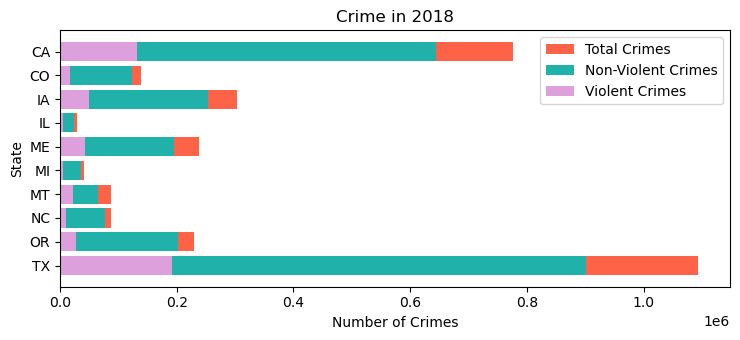

In [34]:
# Horizontal Stacked Bar Graph for Crime
### needs subplot
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

Total_Crime = [1093323,229840,87503,86606,40906,237605,29184,303471,139027,776182]
Non_Violent_Crime = [901275,202936,76934,64391,35265,195441,23583,253224,122485,643861]
Violent_Crime = [192048,26904,10569,22215,5641,42164,5601,50247,16542,132321]
labels = ['TX','OR','NC','MT','MI','ME','IL','IA','CO','CA']

b1 = plt.barh(labels, Total_Crime, color="tomato")
b2 = plt.barh(labels, Non_Violent_Crime, color="lightseagreen")
b3 = plt.barh(labels, Violent_Crime, color="plum")

plt.title("Crime in 2018")
plt.xlabel("Number of Crimes")
plt.ylabel("State")
plt.legend([b1,b2,b3], ["Total Crimes", "Non-Violent Crimes", "Violent Crimes"], loc="upper right")

plt.show()

### Housing Visualization
Summary: The housing price data is visualized using a multiple line graph to display the median house prices per state for the 2018-2022 timeframe. ****This shows that...*

In [19]:
housing_df.head()

,State,2018,2019,2020,2021,2022
0,CA,"539,576","546,365","568,272","678,849","770,635"
1,TX,"203,496","213,051","219,912","254,620","313,171"
2,IL,"199,116","203,379","205,314","230,218","261,490"
3,NC,"194,988","206,680","218,010","254,784","322,528"
4,MI,"159,290","169,243","176,564","205,098","233,470"


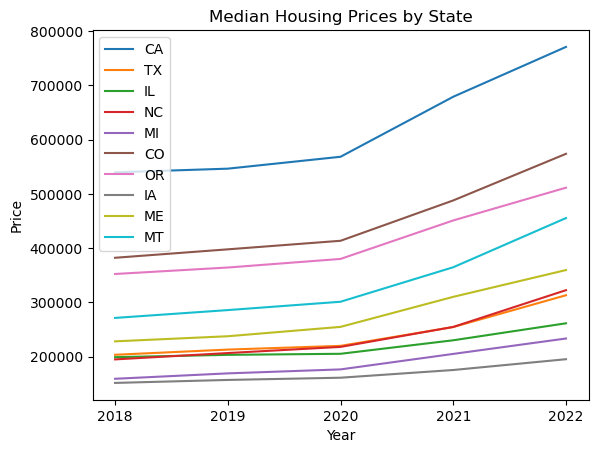

In [20]:
# Line graph for each state's median housing price between 2018-2022
housing_prices = [[539576, 546365, 568272, 678849, 770635],
                  [203496, 213051, 219912, 254620, 313171],
                  [199116, 203379, 205314, 230218, 261490],
                  [194988, 206680, 218010, 254784, 322528],
                  [159290, 169243, 176564, 205098, 233470],
                  [382204, 397746, 413495, 487849, 573716],
                  [352330, 364256, 380062, 450984, 511343],
                  [151652, 157152, 161242, 175456, 195330],
                  [228248, 237650, 254896, 310226, 359572],
                  [271398, 285826, 301200, 364764, 455346]]

states = ['CA', 'TX', 'IL', 'NC', 'MI', 'CO', 'OR', 'IA', 'ME', 'MT']

years = [2018, 2019, 2020, 2021, 2022]

# Create the line graph
for i, state in enumerate(states):
    plt.plot(years, housing_prices[i], label=state)

# Label and title graph
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Median Housing Prices by State')
plt.legend()
plt.xticks(years, [int(year) for year in years])

plt.show()

### Points of Interest Visualizations
Summary: The points of interest data is displayed by using two maps and visualization_type. The first map visualizes the number of POIs for each city in the states of interest. The second map visualizes the number of POIs for each state. The visualization_type helps visualize the POIs taking the population in to consideration. This shows that...

In [21]:
# Map of Points of Interest by City in States of Interest 


cities_poi_map = cities_poi_df.hvplot.points(
    x='Longitude',
    y='Latitude',
    geo=True,
    size=cities_poi_df['City Population'] * 0.001, #Size of plots are in relation to population size of city
    hover_cols=['City', 'State', 'Num of Planetariums', 'Num of Dogs Friendly Places','Num of Vegan Food Places', 'City Population'],
    color='State',
    tiles=True,
    alpha=0.4,
    width=900,
    height=500, 
    title='Points of Interest by City in States of Interest'
)

cities_poi_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (State,_size,City,Num of Planetariums,Num of Vegan Food Places,City Population)

In [22]:
# Map of Points of Interest in States of Interest 

state_poi_map = state_poi_df.hvplot.points(
    x='Longitude',
    y='Latitude',
    geo=True,
    size=state_poi_df['State Population'] * 0.0005, #Size of plots are in relation to population size of city
    hover_cols=['State', 'Longitude', 'Latitude', 'Num of Planetariums', 'Num of Dogs Friendly Places','Num of Vegan Food Places', 'State Population'],
    color='State',
    tiles=True,
    alpha=0.4,
    width=900,
    height=500, 
    title='Points of Interest in States of Interest'
)

state_poi_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (State,_size,Num of Planetariums,Num of Vegan Food Places,State Population)

In [23]:
per_capita_state_poi

,State,State Population,Planetariums per Capita,Dog Friendly Places per Capita,Vegan Food Places per Capita
0,CA,39029342.0,1.819144,59.801162,40.354254
1,CO,5839926.0,0.684940,98.973857,28.082548
2,IA,3200517.0,0.937349,1.562248,0.312450
3,IL,12582032.0,3.338094,33.937285,80.670594
4,ME,1385340.0,0.000000,102.501913,12.993200
5,MI,10034113.0,0.996600,8.371442,13.454104
6,MT,1122867.0,0.000000,14.249239,1.781155
7,NC,10698973.0,0.280401,24.207931,8.505489
8,OR,4240137.0,0.943366,75.705101,87.497173
9,TX,30029572.0,0.366306,27.739323,7.093008


### Comparative Visualizations

#### Crime and Housing Visualization
Summary: The crime data and housing price data are compared by displaying the data in visualization_type. This shows that...*

In [ ]:
# Crime and Housing Visualization

### POI and Housing Visualization
The crime data and housing price data are compared by displaying the data in visualization_type. This shows that...

In [ ]:
# POI and Housing Visualization